In [ ]:
# Homework 2: Boosting and Bagging
#
# This python notebook is for Homework 2 of CS6350 at the University of Utah. It takes the Decision Trees from the previous
# homework and builds on them to implement the Boosting and Bagging algorithms.
#
# @author: Scott Merkley
# @version: October 06, 2024

# **Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os

# **Gain Functions, Node Class, and ID3 Algorithm**

In [2]:
####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                 Entropy and Gain Functions                                                                                                       #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################

# This function takes in a positive and negative numbers for one attribute of a set, the total
# of their entries and calculates the entropy for that single array.
#
def Calculate_Single_Entropy(arr):
  tot = np.sum(arr)
  H_entropy = 0
  for val in arr:
    if val == 0:
      return 0
    else:
      H_entropy += -(val / tot) * math.log2(val / tot)
  return H_entropy


# This function takes in the positive and negative numbers of chances that the attribute has,
# calculates, and returns the entropy.
#
def Entropy(entropy_arr):

  if not isinstance(entropy_arr, np.ndarray):
    entropy_arr = np.array(entropy_arr)

  try:
    if entropy_arr.shape[1] > 1:
      H_entropy = 0
      for arr in entropy_arr:
            H_entropy += np.sum(arr) / np.sum(entropy_arr) * Calculate_Single_Entropy(arr)
      return H_entropy
  except:
      return Calculate_Single_Entropy(entropy_arr)


# This function calculates the gain from given positive and negative values in an array so
# that the decision tree can decide which attribute to use next.
#
# Format of 'entropies':
#
#    [[pos, neg],     First attribute with pos, neg values
#     [pos, neg],     Second attribute with pos, neg values
#     [pos, neg],
#        ...
#     [pos, neg]]     Total pos, neg of system
#
def Gain(df):

  # Check if df is a df, if not, make it a df
  entropies = []
  for col_name in df.columns:
    col_entropy = []
    for val in pd.crosstab(df[col_name], df[df.columns[-1]]).values:
        col_entropy.append(val)

    if col_name == df.columns[-1]:
      # You need to collate these values so that they are in the form [9, 5] instead of [9, 0], [0, 5]
      col_entropy = [max(elements) for elements in zip(*col_entropy)]

    # I want to calculate the entropy for each column here
    entropies.append(Entropy(col_entropy))

  # Calculating the Gain
  entropies = entropies[-1] - entropies
  entropies = entropies[:-1]
  return np.array(entropies)


# This function calculates the Majority Error of a given dataframe, it assumes that the first columns are the attributes and the last column is the labels.
# It returns an array of errors to find the majority from.
#
def Majority_Error(df):
  errors = []
  for col_name in df.columns[:-1]:
    errors.append(1 - pd.crosstab(df[col_name], df[df.columns[-1]]).sum(axis = 1).max() / pd.crosstab(df[col_name], df[df.columns[-1]]).values.sum())
  return np.array(errors)




# This function calculates the Gini Index of a given dataframe, it assumes that the first columns are the attributes and the last column is the labels.
# It returns an array of errors to find the Gini from.
#
def Gini_Index(df):
  gini = []
  for col_name in df.columns[:-1]:
    gini_value = 0
    for val in pd.crosstab(df[col_name], df[df.columns[-1]]).values:
      gini_value += (np.sum(val) / pd.crosstab(df[col_name], df[df.columns[-1]]).values.sum())**2
    gini.append(1 - gini_value)
  return np.array(gini)





####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                     Node Class                                                                                                                   #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################



# This class represents the nodes for the decision tree. The data can be thought of as the name of the tree,
# the children are the leaf nodes.
#
class Node:
  def __init__(self, data = None):
    self.data = data
    self.children = {}
    self.is_leaf = False

  def add_child(self, branch_name, child_node):
    self.children[branch_name] = child_node

  def __getitem__(self, child_name):
    return self.children[child_name]

  def __str__(self):
    return str(self.data)

  def print_tree(self, level = 0):
        # Print the current node's data with indentation
        print(" " * level + str(self.data))
        # Recursively print the children nodes
        for child in self.children.values():
            child.print_tree(level + 2)  # Increases indentation for children



####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                     ID3 Algorithm                                                                                                                #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################



# This function is the decision tree function. It takes in a given data set S, Attributes (ie. column names without the label column name), and
# the Labels for the dataset. It then uses the Node class and Gain functions to create a decision tree for the data set. The user is also able to
# specify a depth for the tree to try to maintain overfitting or underfitting.
#
def ID3(S, Attributes, Labels, method = 'Gain', max_depth = None, current_depth = 0):

  if max_depth != None and not isinstance(max_depth, int):
    max_depth = int(max_depth)

  if not isinstance(Attributes, list):
    attributes_list = []
    for a in Attributes:
      attributes_list.append(a)
    Attributes = attributes_list

  df = pd.DataFrame(S, columns = Attributes)
  outcome_column_name = 'Outcomes'
  df[outcome_column_name] = Labels

  if len(df[outcome_column_name].unique()) == 1:
    leaf = Node(df[outcome_column_name].unique()[0])
    leaf.is_leaf = True
    return leaf

  elif len(Attributes) == 0:
    leaf = Node(df[outcome_column_name].value_counts().idxmax())
    leaf.is_leaf = True
    return leaf # Most common label, not the highest number.

  else:
    if method == 'ME':
      A = Attributes[np.argmax(Majority_Error(df))]
    elif method == 'GI':
      A = Attributes[np.argmax(Gini_Index(df))]
    else:
      A = Attributes[np.argmax(Gain(df))] # Will return the 'best' attribute (aka. column header) that splits S

    # Add a new node until the specified depth
    root = Node(A)

    if max_depth == None or current_depth < max_depth:
      for v in df[A].unique():
        # root.add(Node(v)) # Adding a new tree branch corresponding to A = v
        S_v = df[df[A] == v]

        if S_v.empty:
          leaf = Node(df[outcome_column_name].value_counts().idxmax())
          leaf.is_leaf = True
          root.add_child(v, leaf)

        else:
          # In order to make the tree a certain depth, you could use a count depth on the node class! Then instead of running a leaf you only add a branch (aka. .add())
          L_v = S_v[outcome_column_name].values
          S_v = S_v.drop([A, outcome_column_name], axis = 1)
          A_v = Attributes.copy()
          A_v.remove(A)
          root.add_child(v, ID3(S_v.values, A_v, L_v, method = method, max_depth = max_depth, current_depth = current_depth + 1))

    else:
      leaf = Node(df[outcome_column_name].value_counts().idxmax())
      leaf.is_leaf = True
      return leaf

    return root


####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                    Testing Decision Tree Functions                                                                                               #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################


# This function takes in a decision tree, the test data (as a pandas dataframe), and the row index. It returns the label value that the decision tree returns.
# The function recursively moves down the tree until a leaf node is reached. The leaf nodes value is then returned up the tree.
#
def Test_Tree(tree, test, row_index):
  if tree.is_leaf:
    return tree.data
  else:
    return Test_Tree(tree[test[tree.data][row_index]], test, row_index)



# This function is the driver method for testing the a decision tree. An input tree, test dataframe, outcome column name, and beginning and ending depths
# are required to make the calculations. It then traverses the tree, tests whether the outcomes in the decision tree are the same as the test data.
#
def Test_Decision_Tree(tree, test_df, outcome_column_name, begin_depth, end_depth):
  correct_dictionary = {}
  for m in ['ME', 'GI', 'Gain']:
    correct_list = []
    for depth in range(begin_depth, end_depth):
      tree = ID3(test_df.drop(outcome_column_name, axis = 1).values, list(test_df.drop(outcome_column_name, axis = 1).columns), test_df[outcome_column_name].values, method = m, max_depth = depth)
      is_correct = 0
      for row_index in range(0, len(test_df)):
        try:
          if Test_Tree(tree, test_df, row_index) == test_df[outcome_column_name][row_index]:
            is_correct += 1
        except:
          is_correct += 0
      correct_list.append(is_correct)
    correct_dictionary[m] = correct_list
  return correct_dictionary

# **AdaBoost**

In [54]:
####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                          Class for Adaboost                                                                                                      #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################

class AdaBoost:
  def __init__(self, t_stumps = 0):
    self.t_stumps = t_stumps
    self.alphas = []
    self.stumps = []

  def fit(self, S, Attributes, Labels):
    # Check and see if the provided labels are [-1, 1]
    if not (np.unique(Labels) == np.array([-1, 1])).all:
      raise Exception("Labels must be -1 or 1")

    df = pd.DataFrame(S, columns = Attributes)
    S_i = S

    # Initialize Weights
    weights = np.ones(S.shape[0]) / S.shape[0]

    # Train the stumps
    for s in range(self.t_stumps):

      # Get a subset of S that is S_i
      cumulative_weights_for_indexing = np.cumsum(weights)
      indices = []
      for j in range(S_i.shape[0]): # Could take a subset of 20% of S (in the video they say to take the samples as the same number as was given aka. 100%)
        indices.append(np.searchsorted(cumulative_weights_for_indexing, np.random.rand()))
      S_i = S[indices]
      Labels_i = Labels[indices]

      # Train the individeual stump, Attributes is just the columns of S, depth of a stump is 1 by definition
      stump = ID3(S_i, Attributes, Labels_i, method = 'Gain', max_depth = 1)

      # Calculate the error using the weight
      predictions = np.array([stump[pd.DataFrame(S_i, columns = Attributes)[stump.data][i]].data for i in range(S_i.shape[0])])
      incorrect = (predictions != Labels_i).astype(int)
      weighted_errors = np.sum(weights * incorrect) / np.sum(weights)

      # Calculate the weight of the stump
      if weighted_errors == 0:
        alpha = 1
      else:
        alpha = 0.5 * np.log((1 - weighted_errors) / (weighted_errors + 1e-10)) # adding a small term so that you never divide by 0

      self.alphas.append(alpha)
      self.stumps.append(stump) # Try doing a dictionary and pulling the specific stump you need? {}

      # Update the Weights
      weights *= np.exp(-alpha * Labels_i.astype(int) * incorrect)
      weights /= np.sum(weights) # Normalize Weights

  def predict(self, S):
    # Find the predictions for a given dataset using alphas
    final_predictions = np.zeros(S.shape[0])
    for alpha, stump in zip(self.alphas, self.stumps):
      predictions = np.array([stump[S[stump.data][i]].data for i in range(S.shape[0])])
      final_predictions += alpha * predictions

    # Lastly, return the signs of the predictions
    return np.sign(final_predictions)


# **AdaBoost: Bank Marketing Testing**

In [55]:
# Mount Google Drive if it hasnt been already
if not os.path.exists('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')
  print("Google Drive mounted successfully.")


# Downloading Car Evaluation CSV from website so I dont have to store it locally.
columns = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
    'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
    'previous', 'poutcome', 'y'
]

bank_data = pd.read_csv('/content/drive/MyDrive/Personal/UofU/Grad School/CS 6350 - Machine Learning/1 - HW/HW01 - Decision Trees/bank.zip (Unzipped Files)/train.csv', names = columns)
bank_test_data = pd.read_csv('/content/drive/MyDrive/Personal/UofU/Grad School/CS 6350 - Machine Learning/1 - HW/HW01 - Decision Trees/bank.zip (Unzipped Files)/test.csv', names = columns)
bank_test_data['y'] = bank_test_data['y'].replace({'yes' : 1, 'no' : -1})

# Change all these to binary using threshold age, balance, day, duration, days, previous, campaign
for column_name in ['age', 'balance', 'day', 'duration', 'pdays', 'previous', 'campaign']:
  bank_test_data[column_name] = bank_test_data[column_name] > bank_data[column_name].median()
  bank_data[column_name] = bank_data[column_name] > bank_data[column_name].median()

# Create Decision Tree from Dataset
# bank_tree = ID3(bank_data.drop('y', axis = 1).values, list(bank_data.drop('y', axis = 1).columns), bank_data['y'].values, method = 'Gain', max_depth = 1)
# draw_dot(bank_tree)


# Change the Labels to 1 or -1
pd.set_option('future.no_silent_downcasting', True)
bank_data['y'] = bank_data['y'].replace({'yes' : 1, 'no' : -1})


number_of_trees = [1, 5, 10, 50, 100, 250, 500]
for n in number_of_trees:
  bank_learner = AdaBoost(t_stumps = n)
  bank_learner.fit(bank_data.drop('y', axis = 1).values, bank_data.drop('y', axis = 1).columns.tolist(), bank_data['y'].values)
  b = bank_learner.predict(bank_test_data) == bank_test_data['y'].values

  print(n, np.sum(b))

1 4376
5 4376
10 4376
50 4376
100 4376
250 4376


KeyError: 'dec'

# **Bagging**

In [51]:
####################################################################################################################################################################################################################################
#                                                                                                                                                                                                                                  #
#                                                                                                        Class for RandomForest                                                                                                    #
#                                                                                                                                                                                                                                  #
####################################################################################################################################################################################################################################

import multiprocessing as mp



class RandomForest:
  def __init__(self, n_trees = 0):
    self.n_trees = n_trees
    self.forest = []

  def Train_Trees_MP(self, args):
      S, Attributes, Labels = args
      return ID3(S, Attributes, Labels, method = 'Gain')

  def fit(self, S, Attributes, Labels):
    df = pd.DataFrame(S, columns = Attributes)
    S_i = S

    # Initialize Weights
    weights = np.ones(S.shape[0]) / S.shape[0]

    # Make a list to give to the multiprocessing
    args = []

    # Train the stumps
    for t in range(self.n_trees):
      # Get a subset of S that is S_i
      cumulative_weights_for_indexing = np.cumsum(weights)
      indices = []
      for j in range(np.ceil(S_i.shape[0] * 0.25).astype(int)): # Could take a subset of 20% of S
        indices.append(np.random.randint(S.shape[0]))
      S_i = S[indices]
      Labels_i = Labels[indices]
      args.append((S_i, Attributes, Labels_i))

    # Run Multiprocessing
    with mp.Pool(mp.cpu_count()) as pool:
      # Train the individual stump, Attributes is just the columns of S, depth of a stump is 1 by definition
      trees = pool.map(self.Train_Trees_MP, args)

    # Add all the trees to the forest
    self.forest.extend(trees)

  def predict(self, S):
    # Find the predictions for a given dataset using alphas
    final_predictions = []
    for i in range(S.shape[0]):
      for t in self.forest:
        try:
          # Add the random tree if it works, if it doesn't, continue onto the next tree until you find one that works
          tree = Test_Tree(t, S, i)
          final_predictions.append(tree)
          break
        except:
          if t == self.forest[-1]:
            try:
              final_predictions.append(S.iloc[:, -1].mode()[0]) # Just give it the most common value
            except:
              final_predictions.append('NA') # Just give it a wrong value

    # Lastly, return the signs of the predictions
    return final_predictions


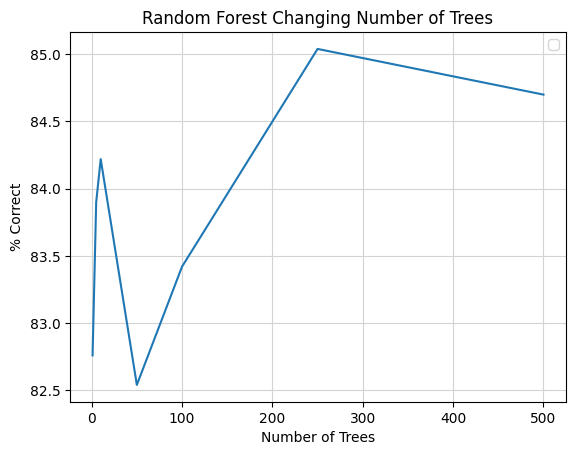

In [52]:
# Mount Google Drive if it hasnt been already
if not os.path.exists('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')
  print("Google Drive mounted successfully.")


# Downloading Car Evaluation CSV from website so I dont have to store it locally.
columns = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
    'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
    'previous', 'poutcome', 'y'
]

bank_data = pd.read_csv('/content/drive/MyDrive/Personal/UofU/Grad School/CS 6350 - Machine Learning/1 - HW/HW01 - Decision Trees/bank.zip (Unzipped Files)/train.csv', names = columns)
bank_test_data = pd.read_csv('/content/drive/MyDrive/Personal/UofU/Grad School/CS 6350 - Machine Learning/1 - HW/HW01 - Decision Trees/bank.zip (Unzipped Files)/test.csv', names = columns)

# Change all these to binary using threshold age, balance, day, duration, days, previous, campaign
for column_name in ['age', 'balance', 'day', 'duration', 'pdays', 'previous', 'campaign']:
  bank_test_data[column_name] = bank_test_data[column_name] > bank_data[column_name].median()
  bank_data[column_name] = bank_data[column_name] > bank_data[column_name].median()


correct_over_time = []
number_of_trees = [1, 5, 10, 50, 100, 250, 500]
for n in number_of_trees:
  bank_learner = RandomForest(n_trees = n)
  bank_learner.fit(bank_data.drop('y', axis = 1).values, bank_data.drop('y', axis = 1).columns.tolist(), bank_data['y'].values)
  b = bank_learner.predict(bank_test_data) == bank_test_data['y'].values
  correct_over_time.append(np.sum(b) / len(bank_test_data['y'].values) * 100)

plt.plot(number_of_trees, correct_over_time)
plt.title(f'Random Forest Changing Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('% Correct')
plt.grid(color = 'lightgrey')
# plt.legend()
# plt.show()